In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import *
from dataclasses import dataclass

The initial idea was to encode (base, length) in the capability using an exponent: base = $b * 2^l$, b = 7 bytes (56 bits) and l = 1 byte (8 bits).
This allows encoding of ranges up to $2^255$ bytes in length, which we prob don't need.
It also limits the ranges to be pow2 size and pow2 aligned. pow2 size is a real bugbear.
Thought: come up with different configurations for storing a length and evaluate them by seeing how granular they get for values under 1KiB. Assume once you get over 1KiB the previous granularity shown is sufficient to power up and up and up.

First thought: encode $2^{l_1} * (1 + 2^{-l_2})$, i.e. $32 * 1.5 = 48$. This allows exact storage of any length with up to two binary bits set.

In [2]:
MAX_LENGTH_TO_EVAL = 4096 # 4KiB

def gen_closest_representable_map(exact_storable_lengths: List[int]) -> List[int]:
    exact_storable_lengths.sort()
    # Always round up, because we want to allow access to all requested bytes
    next_to_represent = 0
    distance_from_next_storable = []
    for exact_l in exact_storable_lengths:
        if exact_l > MAX_LENGTH_TO_EVAL:
            break
        distance_from_next_storable.extend(
            exact_l - l
            for l in range(next_to_represent, exact_l + 1)
        )
        next_to_represent = exact_l + 1
    assert len(distance_from_next_storable) == MAX_LENGTH_TO_EVAL + 1

    return distance_from_next_storable

def full_evaluate_length_scheme(name: str, exact_storable_lengths: List[int]):   
    # Evaluate a given length by checking, for each length, how far away the closest higher storable length is.
    distance_from_next_storable = gen_closest_representable_map(exact_storable_lengths)
    max_dist = max(distance_from_next_storable)

    fix, ax = plt.subplots()
    bar = ax.plot(list(range(MAX_LENGTH_TO_EVAL+1)), distance_from_next_storable)
    ax.set(title=f'Evaluation for {name}', ylabel='Extra accessible bytes',xticks = [i * 512 for i in range(9)], yticks=[i*256 for i in range(9) if i * 256 - max_dist < 256])
    plt.show()

def evaluate_length_scheme_against_linear(name: str, exact_storable_lengths: List[int], linear_step: int = 64):
    # Evaluate a given length by checking for each multiple of a linear step, how far away the closest higher storable length is
    # Use 64 bytes, the length of a cache line, as the linear step because sub-cache-line-sharing is bad for everyone
    full_distance_from_next_storable = gen_closest_representable_map(exact_storable_lengths)
    distance_from_next_storable = {
        i: full_distance_from_next_storable[i]
        for i in range(len(full_distance_from_next_storable))
        if (i < linear_step) or ((i % linear_step) == 0)
    }

    max_dist = max(distance_from_next_storable.values())
    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)
    
    fig.suptitle(f'Evaluation for {name}, linstep = {linear_step}')
    axs[0].plot(list(range(linear_step+1)), [distance_from_next_storable[i] for i in range(linear_step + 1)])
    axs[0].set(title=f'Up to {linear_step} bytes', ylabel='Extra accessible bytes', yticks = [0, 8, 16, 24, 32])
    axs[0].grid(True)
    axs[1].plot(list(distance_from_next_storable.keys()), list(distance_from_next_storable.values()))
    axs[1].set(title=f'Up to 4KiB', ylabel='Extra accessible bytes',xticks = [i * 512 for i in range(9)], yticks=[i*256 for i in range(9) if i * 256 - max_dist < 256])
    axs[1].grid(True)
    plt.show()

First, we can look at schemes which allow all one-bit, two-bit, and three-bit numbers to be encoded.
This doesn't consider how those numbers are encoded.
The original scheme is equivalent to only allowing one-bit lengths.

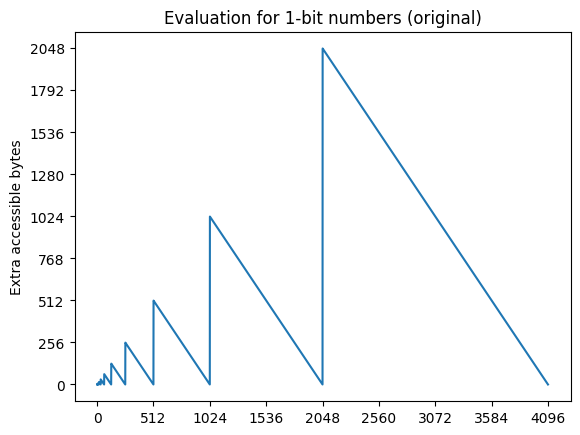

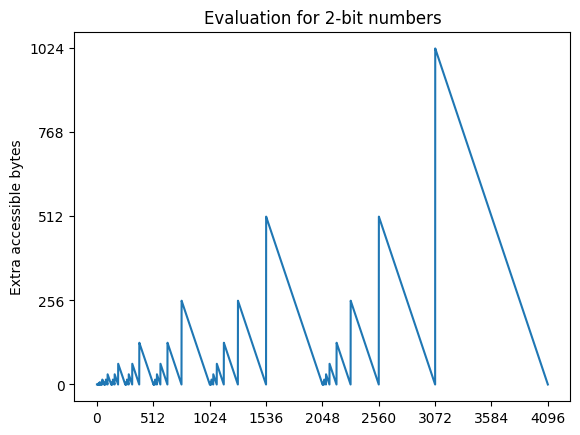

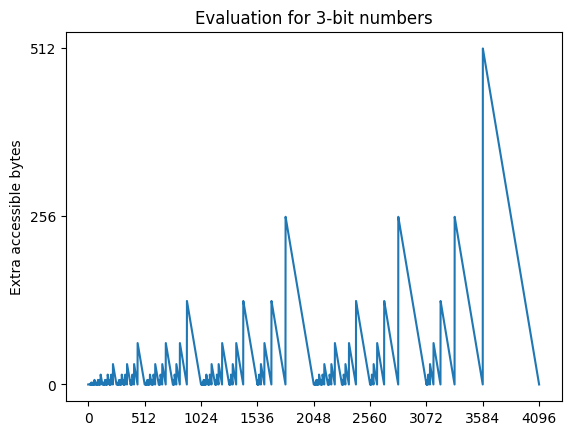

In [3]:
all_1bit_numbers = [x for x in range(MAX_LENGTH_TO_EVAL + 1) if f"{x:b}".count("1") <= 1]
all_2bit_numbers = [x for x in range(MAX_LENGTH_TO_EVAL + 1) if f"{x:b}".count("1") <= 2]
all_3bit_numbers = [x for x in range(MAX_LENGTH_TO_EVAL + 1) if f"{x:b}".count("1") <= 3]
# all_4bit_numbers = [x for x in range(MAX_LENGTH_TO_EVAL + 1) if f"{x:b}".count("1") <= 4]
# all_5bit_numbers = [x for x in range(MAX_LENGTH_TO_EVAL + 1) if f"{x:b}".count("1") <= 5]

full_evaluate_length_scheme("1-bit numbers (original)", all_1bit_numbers)
full_evaluate_length_scheme("2-bit numbers", all_2bit_numbers)
full_evaluate_length_scheme("3-bit numbers", all_3bit_numbers)
# evaluate_length_scheme("4-bit numbers", all_4bit_numbers)
# evaluate_length_scheme("5-bit numbers", all_5bit_numbers)

# evaluate_length_scheme_against_linear("All 1-bit numbers (original)", all_1bit_numbers)
# evaluate_length_scheme_against_linear("All 2-bit numbers", all_2bit_numbers, linear_step=1)
# evaluate_length_scheme_against_linear("All 3-bit numbers", all_3bit_numbers, linear_step=1)

We can see that no matter what we choose precision always gets worse near the top end.
It may be arguable that once we go beyond 2048, each allocation will get its own page anyway which effectively removes the need for representing ranges between 2048 and 4096 - this requires further study and actually examining what base/range allocations are typically made.
Let's examine a few subsets of 2 and 3-bit encodings I was considering:

First, a two-bit code where the consecutive top two bits are set, not two arbitrary bits.

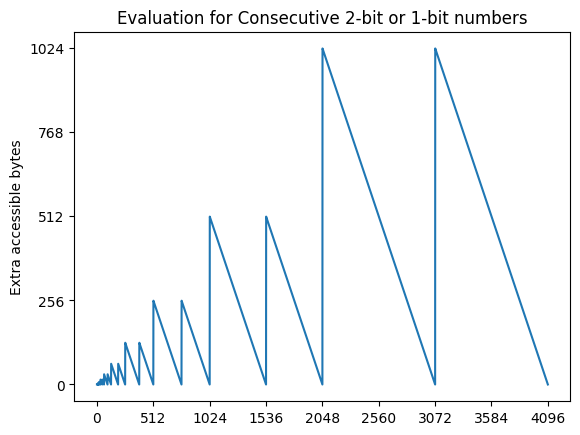

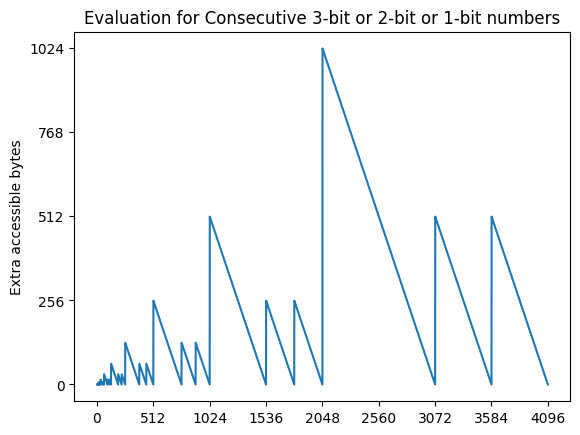

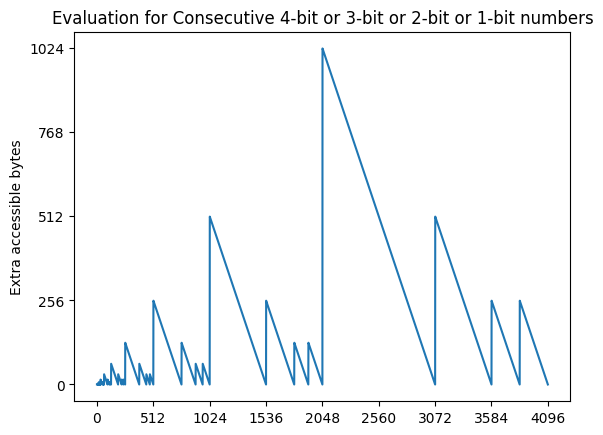

In [4]:
consec_2bit_numbers = [int("11" + "0"*m, 2) for m in range(11)] + all_1bit_numbers
full_evaluate_length_scheme("Consecutive 2-bit or 1-bit numbers", consec_2bit_numbers)

consec_3bit_numbers = [int("111" + "0"*m, 2) for m in range(10)] + consec_2bit_numbers
full_evaluate_length_scheme("Consecutive 3-bit or 2-bit or 1-bit numbers", consec_3bit_numbers)

consec_4bit_numbers = [int("1111" + "0"*m, 2) for m in range(9)] + consec_3bit_numbers
full_evaluate_length_scheme("Consecutive 4-bit or 3-bit or 2-bit or 1-bit numbers", consec_4bit_numbers)

[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96, 128, 160, 192, 256, 320, 384, 512, 640, 768, 1024, 1280, 1536, 2048, 2560, 3072, 4096]


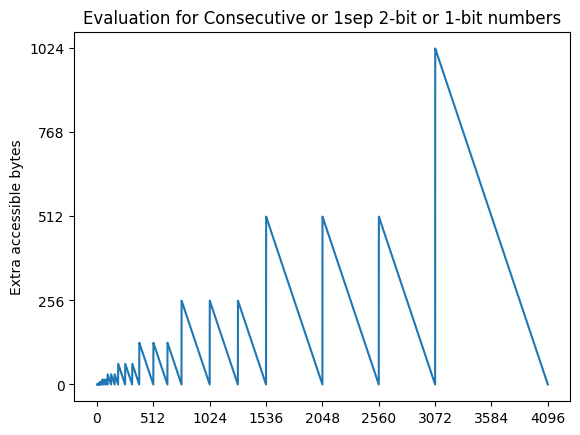

[0, 1, 2, 4, 5, 6, 7, 8, 10, 12, 14, 16, 20, 24, 28, 32, 40, 48, 56, 64, 80, 96, 112, 128, 160, 192, 224, 256, 320, 384, 448, 512, 640, 768, 896, 1024, 1280, 1536, 1792, 2048, 2560, 3072, 3584, 4096]


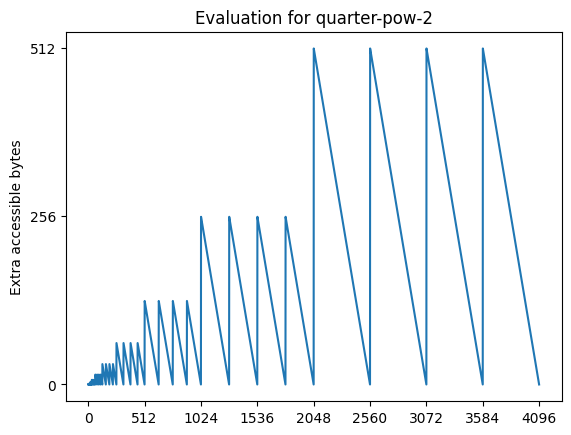

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 36, 40, 44, 48, 52, 56, 60, 64, 72, 80, 88, 96, 104, 112, 120, 128, 144, 160, 176, 192, 208, 224, 240, 256, 288, 320, 352, 384, 416, 448, 480, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1152, 1280, 1408, 1536, 1664, 1792, 1920, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096, 4608, 5120, 5632, 6144, 6656, 7168, 7680]


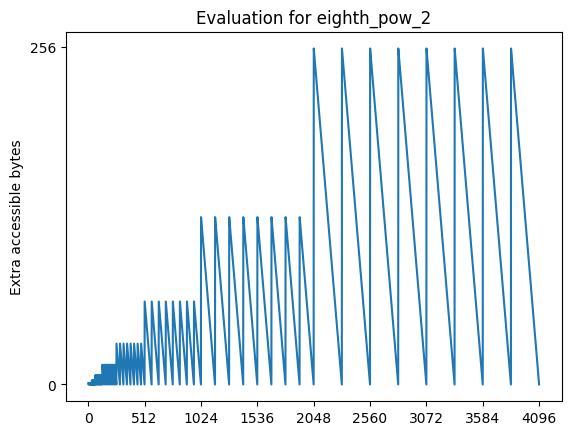

In [5]:
consec_or1sep_2bit_numbers = [int("11" + "0"*m, 2) for m in range(11)] + [int("101" + "0"*m, 2) for m in range(10)] + all_1bit_numbers
print(sorted(consec_or1sep_2bit_numbers))
full_evaluate_length_scheme("Consecutive or 1sep 2-bit or 1-bit numbers", consec_or1sep_2bit_numbers)

quarter_pow_2 = [int("110" + "0"*m, 2) for m in range(10)] + [int("101" + "0"*m, 2) for m in range(10)] + [int("111" + "0"*m, 2) for m in range(10)] + all_1bit_numbers
print(sorted(quarter_pow_2))
full_evaluate_length_scheme("quarter-pow-2", quarter_pow_2)

eighth_pow_2 = [int(2**r * (1 + l/8)) for l in range(8) for r in range(13)]
print(sorted(set(eighth_pow_2)))
full_evaluate_length_scheme("eighth_pow_2", eighth_pow_2)

Turns out floating-point is pretty rad. Who knew?
I like this eighth_pow_2 setup - how many bits does it take?
Two components: exponent and mantissa, mantissa is 3 bits (0,1,2,3,4,5,6,7) and exponent is up to 64 -> 6 bits.
This gives us at most 55 bits to use for encoding the base.

So based on this, the next problem: how do you represent the base?
Theory: we can design a base encoding by trying to represent some X-aligned array of elements of size Y - $base = n * X + i * Y$?

$Y = 2^e * (1 + r/8)$

let $X = 2^e, Y = X * (1 + r/8)$

$base = n * 2^e + i * 2^e * (1 + r/8) = (n + i) * 2^e + (i * r) * 2^e / 8 = (n + i + (i * r / 8)) * 2^e + (i * r \% 8) * 2^{e-3}$

=> we can store $b_1 = (n + i + (i * r / 8))$ and $b_2 = (i * r \% 8)$ - how long are those?
- r is 3 bits
- $b_2 < 8$ => b2 is *also* 3 bits
- in a simplified case where $X = Y$ i.e. $r = 0$, all we need is $b_1$. Say the maximum we want to be able to represent is "the 4KiB page at the end of the $2^{64}$ addr space", we need 52 bits for that...
- $b_1$ is 52 bits?

Therefore the bit layout would be something like
- `b1[0:51]`
- `b2[52:54]`
- `r[55:57]`
- `e[58:63]`

This is better than before, it makes all the bits useful and provides a better size distribution, but it doesn't give us any spare bits :(
Note: this is the same as saying $b$ is 52.3 fixed-point lolllllll

What if we used quarter_pow_2?
b2 and r would become two bits each instead of three, saving two bits total, but b1 doesn't change. b1 only changes if we change the maximum we want to represent, but I don't want to do that.
Ok, well how many bits do we *want* spare?
Say we just wanted to use the spare bits for key IDs... we have 7 spare currently if we have 3x 4:15 `log d: i` caveats.
So 7 spare bits with eighth_pow_2 => **128** secret keys. That doesn't sound like enough.
If we drop to quarter_pow_2 we get 9 bits => **512** secret keys. That doesn't sound like enough either?
For reference, my home Linux box has a `/proc/sys/kernel/pid_max` of $2^{22} = 4194304$

augggh. We may need to cut into the signature bits. This means the attacker needs to guess ~100 bits or 64 bits instead of 128, but I'm *really* not sure how AES stands up to "haha I partially know the key" attacks.

Alternatively... how often are people really going to shrink the capability *and* pass it around? you could just do a single 5:31 caveat and have 28 bits left for your secret key ID. 2MiB hugepages = 2^21, which means a base capability of 2^52 can still be subdivided into pages... that's a bit far fetched? but is it?? or just 2x 4:15 with 26 bits for a secret key and more flexibility - maybe 2x 4:16 + 2 enable bits with 22 bits for exact equivalency to the kernel?

I need to look into how often capabilities need to be *shrunk*. If your actors are elements in a consumer system, how likely is it that some initial actor A will create a capability for B, B will shrink that and pass it to C... will C ever try to shrink that and pass it around? Any capabilities originating from A shouldn't have caveats enabled, because A has the secret(s), and if any actor wants to pass the *same* access to another actor that doesn't use any caveats either.

Another possiblity for the base/length - b2 is always 0 if r is 0. Could have something where b is 52.0 fixed when r is 0, then it's 49.3 when r is nonzero. This would mean you get three extra bits in the top, and you'd assume that you aren't going to get weird offsets near the top.
Ex. 4KiB * 1.75 = 7KiB, max b = 2^49 * 4KiB + 7 * 512 = 2^49 * 2^12 + 7 * 2^9 = 2^61 + 7*2^9...
not great, but not terrible. Again, studies needed on when these weird allocs are actually used, and especially when they're actually used in a device-to-device context.

Maybe a completely separate floating point for the base????

B is 55 bits, so you can always control 55 bits in the base address.

The current way is 
- if e = 0, base = 0'12 | B\[54:3\]
- if e = 1, base = 0'11 | B\[54:2\]
- if e = 2, base = 0'10 | B\[54:1\]
- if e = 3, base = 0'9 | B;
- if e = 4, base = 0'8 | B | 0'1
- if e = 5, base = 0'7 | B | 0'2
- if e = 12, base = B | 0'9
- if e = 13, base = B\[53:0\] | 0'10... ? this is throwing away bits!

Instead of doing a weird multiply, you can do:
- if e = 0, base = 0'9 | B
- if e = 1, base = 0'9 | B
- if e = 2, base = 0'9 | B
- if e = 3, base = 0'9 | B
- if e = 4, base = 0'8 | B | 0'1
- ...
- if e >= 12, base = B | 0'9

If you want, you could force 64-byte alignment:
- if e = 0, base = 0'3 | B | 0'6
- if e = 1, base = 0'3 | B | 0'6
- ...
- if e = 9, base = 0'3 | B | 0'6; if length is < (512 * (1 + r/8)); you are 64-byte aligned
- if e = 10, base = 0'2 | B | 0'7; if length is 1024 * (1 + r/8); you are 128-byte aligned
- if e = 11, base = 0'1 | B | 0'8; if length is 2048 * (1 + r/8); you are 256-byte aligned
- if e = 12, base = B | 0'9; if length is 4096 * (1 + r/8); you are 512-byte aligned

This gives you extra precision for the placement of <512-byte ranges at the expense of the top seven-eighths of the address space :(
Need to place MMIO addresses carefully?

Total Bits,64
Base,55
Length,6.3 floating


length_exp,l >=,l <,base,base align,base range
0,1B,2B,0'3 | B | 0'6,64B,1/8
1,2B,4B,0'3 | B | 0'6,64B,1/8
2,4B,8B,0'3 | B | 0'6,64B,1/8
3,8B,16B,0'3 | B | 0'6,64B,1/8
4,16B,32B,0'3 | B | 0'6,64B,1/8
5,32B,64B,0'3 | B | 0'6,64B,1/8
6,64B,128B,0'3 | B | 0'6,64B,1/8
7,128B,256B,0'3 | B | 0'6,64B,1/8
8,256B,512B,0'3 | B | 0'6,64B,1/8
9,512B,1KiB,0'3 | B | 0'6,64B,1/8


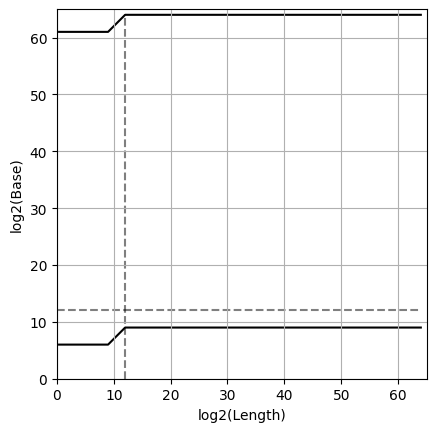

Total Bits,64
Base,55
Length,6.3 floating


length_exp,l >=,l <,base,base align,base range
0,1B,2B,0'0 | B | 0'9,512B,1/1
1,2B,4B,0'0 | B | 0'9,512B,1/1
2,4B,8B,0'0 | B | 0'9,512B,1/1
3,8B,16B,0'0 | B | 0'9,512B,1/1
4,16B,32B,0'0 | B | 0'9,512B,1/1
5,32B,64B,0'0 | B | 0'9,512B,1/1
6,64B,128B,0'0 | B | 0'9,512B,1/1
7,128B,256B,0'0 | B | 0'9,512B,1/1
8,256B,512B,0'0 | B | 0'9,512B,1/1
9,512B,1KiB,0'0 | B | 0'9,512B,1/1


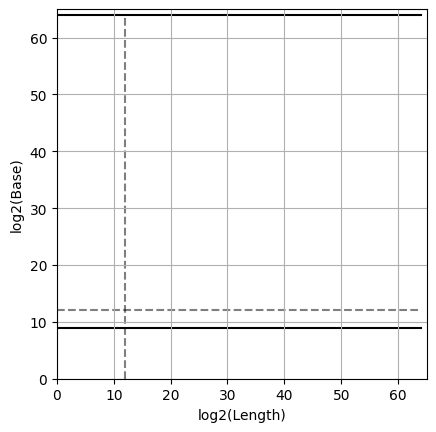

Total Bits,64
Base,53
Length,6.5 floating


length_exp,l >=,l <,base,base align,base range
0,1B,2B,0'5 | B | 0'6,64B,1/32
1,2B,4B,0'5 | B | 0'6,64B,1/32
2,4B,8B,0'5 | B | 0'6,64B,1/32
3,8B,16B,0'5 | B | 0'6,64B,1/32
4,16B,32B,0'5 | B | 0'6,64B,1/32
5,32B,64B,0'5 | B | 0'6,64B,1/32
6,64B,128B,0'5 | B | 0'6,64B,1/32
7,128B,256B,0'5 | B | 0'6,64B,1/32
8,256B,512B,0'4 | B | 0'7,128B,1/16
9,512B,1KiB,0'3 | B | 0'8,256B,1/8


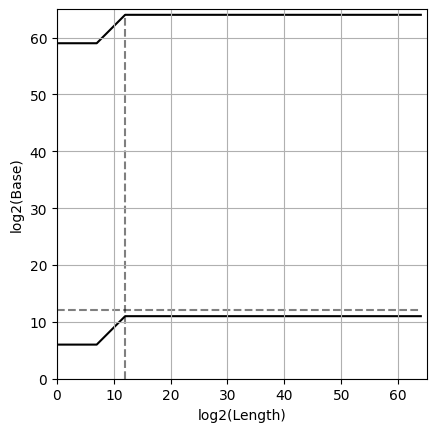

Total Bits,64
Base,53
Length,6.5 floating


length_exp,l >=,l <,base,base align,base range
0,1B,2B,0'3 | B | 0'8,256B,1/8
1,2B,4B,0'3 | B | 0'8,256B,1/8
2,4B,8B,0'3 | B | 0'8,256B,1/8
3,8B,16B,0'3 | B | 0'8,256B,1/8
4,16B,32B,0'3 | B | 0'8,256B,1/8
5,32B,64B,0'3 | B | 0'8,256B,1/8
6,64B,128B,0'3 | B | 0'8,256B,1/8
7,128B,256B,0'3 | B | 0'8,256B,1/8
8,256B,512B,0'3 | B | 0'8,256B,1/8
9,512B,1KiB,0'3 | B | 0'8,256B,1/8


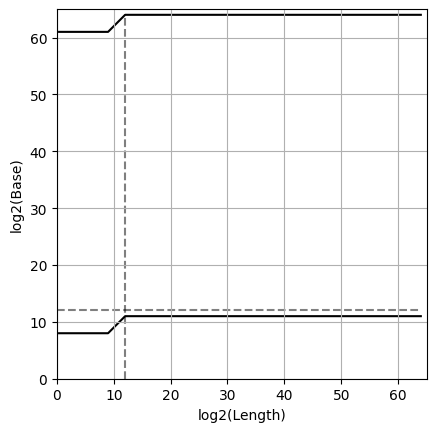

Total Bits,76
Base,58
Length,6.12 floating


length_exp,l >=,l <,base,base align,base range
0,1B,2B,0'0 | B | 0'6,64B,1/1
1,2B,4B,0'0 | B | 0'6,64B,1/1
2,4B,8B,0'0 | B | 0'6,64B,1/1


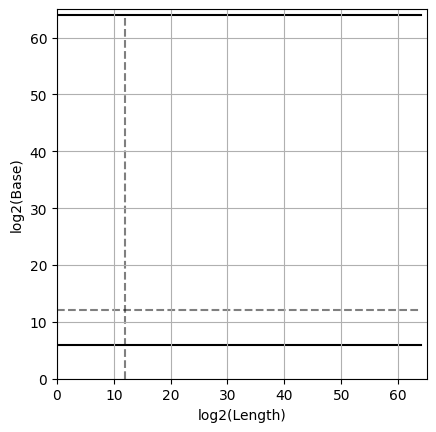

In [13]:
from IPython.display import HTML

def display_max_bit_size(n_bits):
    suffix = ["B", "KiB", "MiB", "GiB", "TiB", "PiB", "EiB"]
    for pow_idx in range((len(suffix) - 1), -1, -1):
        if n_bits >= (10 * pow_idx):
            return f"{2**(n_bits - 10 * pow_idx)}{suffix[pow_idx]}"
    return "0B"

@dataclass
class FixedBaseFloatingLengthRange:
    len_exp_bits: int # The number of bits used to represent the pow2 portion of the range length. Usually 6 because you need to represent lengths of 2**(2**6) = 2**64 to capture the whole address space. Certainly being limited to 2**32 (4GB) ranges would be very sad.
    len_man_bits: int # The number of bits used to represent fractional lengths, i.e. those which are some fraction of a power of two.
    base_bits: int # The total number of potentially-nonzero bits of the base, which is shifted based on the length-exponent to determine the final base address. NOTE: this is shifted by the length-exponent, NOT multiplied by the length - don't want a great big 64-bit multiplier in our hardware if we can avoid it.
    # When constructing 
    
    min_base_align_bits: int # The minimum alignment for the base, which is to say the number of padding bits on the right that are always zero no matter what.
    exp_for_max_base_align: int # The exponent for which the base is aligned all the way to the left i.e. gives access to the max 64-bit addrspace for the first time. All exponents lower than this will sacrifice zero bits at the top of the base to get more detail at the bottom

    def describe(self):
        display(HTML(pd.DataFrame([
            ("Total Bits", f"{self.len_exp_bits + self.len_man_bits + self.base_bits}"),
            ("Base", f"{self.base_bits}"),
            ("Length", f"{self.len_exp_bits}.{self.len_man_bits} floating"),
        ]).to_html(index=False, header=False)))

        max_base_align_bits = max(64 - self.base_bits, 0)
        exp_for_min_base_align = self.exp_for_max_base_align - (max_base_align_bits - self.min_base_align_bits)
        bottom_align_bits = {
            e: min(max_base_align_bits, self.min_base_align_bits + max(0, e - exp_for_min_base_align))
            for e in range(self.exp_for_max_base_align + 2 + 1)
        }
        display(HTML(pd.DataFrame([
            (e, display_max_bit_size(e), display_max_bit_size(e+1), f"0'{max_base_align_bits - align} | B | 0'{align}", display_max_bit_size(align), f"1/{2**(max_base_align_bits - align)}")
            for e, align in bottom_align_bits.items()
        ], columns=["length_exp", "l >=", "l <", "base", "base align", "base range"]).to_html(index=False)))

    def graph_ranges(self):
        fig, ax = plt.subplots()
        ax.set(xlabel="log2(Length)", ylabel="log2(Base)")

        max_base_align_bits = max(64 - self.base_bits, 0)
        exp_for_min_base_align = self.exp_for_max_base_align - (max_base_align_bits - self.min_base_align_bits)
        
        lims = [
            0,
            65
        ]

        bottom_bit_of_base_x = [0, exp_for_min_base_align, self.exp_for_max_base_align, 64]
        bottom_bit_of_base_y = [self.min_base_align_bits, self.min_base_align_bits, max_base_align_bits, max_base_align_bits]
        
        ax.plot(bottom_bit_of_base_x, bottom_bit_of_base_y, 'k-', alpha=1.0, zorder=0)
        ax.plot(bottom_bit_of_base_x, [y + self.base_bits for y in bottom_bit_of_base_y], 'k-', alpha=1.0, zorder=0)

        ax.plot([0, 64], [12, 12], 'k--', alpha=0.5, zorder=1)
        ax.plot([12, 12], [0, 64], 'k--', alpha=0.5, zorder=1)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.grid()
        plt.show()


sliding_64byte_min_align = FixedBaseFloatingLengthRange(
    len_exp_bits = 6,
    len_man_bits = 3,
    base_bits = 55,
    min_base_align_bits = 6,
    exp_for_max_base_align = 12,
)
sliding_64byte_min_align.describe()
sliding_64byte_min_align.graph_ranges()

sliding_512byte_min_align = FixedBaseFloatingLengthRange(
    len_exp_bits = 6,
    len_man_bits = 3,
    base_bits = 55,
    min_base_align_bits = 9,
    exp_for_max_base_align = 12,
)
sliding_512byte_min_align.describe()
sliding_512byte_min_align.graph_ranges()

sliding_64byte_min_align_morelength = FixedBaseFloatingLengthRange(
    len_exp_bits = 6,
    len_man_bits = 5,
    base_bits = 53,
    min_base_align_bits = 6,
    exp_for_max_base_align = 12
)
sliding_64byte_min_align_morelength.describe()
sliding_64byte_min_align_morelength.graph_ranges()
#the problem with this is the alignment offset e.g. it seems useful for addresses to be aligned to length_exp/3, not just length_exp.
#if we set 4KiB as the exp_for_max_base_align, then we need the max_base_align to be 4KiB/8 = 512B = 9 bits, which means we need base_bits = 64 - 9 = 55.

sliding_256byte_min_align_morelength = FixedBaseFloatingLengthRange(
    len_exp_bits = 6,
    len_man_bits = 5,
    base_bits = 53,
    min_base_align_bits = 8,
    exp_for_max_base_align = 12
)
sliding_256byte_min_align_morelength.describe()
sliding_256byte_min_align_morelength.graph_ranges()
#the problem with this is the alignment offset e.g. it seems useful for addresses to be aligned to length_exp/3, not just length_exp.
#if we set 4KiB as the exp_for_max_base_align, then we need the max_base_align to be 4KiB/8 = 512B = 9 bits, which means we need base_bits = 64 - 9 = 55.

full_base = FixedBaseFloatingLengthRange(
    len_exp_bits = 6,
    len_man_bits = 12,
    base_bits = 58,
    min_base_align_bits = 6,
    exp_for_max_base_align = 0
)
full_base.describe()
full_base.graph_ranges()

In [7]:
# OK, we need a scheme for coming up with this stuff.

# First: pick your min length/alignment. It's sensible to take a min alignment of 64, because these are usually cache-coherent systems talking to each other which will usually have a granularity of at least 64 bytes.
#        Could also take 4KiB pages as the min length/alignment.
#        If you're picking a min alignment, it doesn't make sense to be able to represent lengths smaller than that min alignment.
#        e.g. if the min alignment was 64 bytes, and the min length was 4 bytes, you can only represent regions of (64n, 64n + 4) and not (64n + 4, 64n + 8), (64n + 8, 64n + 12)...
#        Right now I do not intend for these capabilities to enforce fine-grained correctness, I only intend them to enforce safety. CHERI uses more bits (we want 64bit base/length, not 64 + 40 = 104bits) to get more precision to try and get both.
# 64 = 6 bits of the base are all zero
# 4KiB = 12 bits of the base are all zero
MIN_REPRESENTABLE_ALIGN_ZERO_BITS = 6

# Next: pick the min alignment for full 64-bit address range access.
# In the above format, I only chose to have full address range access for 512B (9-bit) ranges, and force some top bits to zero for smaller lengths
# This could be seen as a bet on memory usage increasing: right now CPUs only have an internal address bus up to 48-bits (256TB) or 52-bits (4PB). As we approach 64-bit (16EB), we might be able to bet that we don't *need* to represent tiny ranges near the top of that space??
MIN_FULL_ADDR_ALIGN_ZERO_BITS = 9

# The number of base addr bits can be calculated from this:
BASE_ADDR_TOTAL_BITS = 64 - MIN_FULL_ADDR_ALIGN_ZERO_BITS

# The number of length bits we have remaining is also calculable from this:
LENGTH_TOTAL_BITS = 64 - BASE_ADDR_TOTAL_BITS # = MIN_FULL_ADDR_ALIGN_ZERO_BITS